In [2]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
DATA_DIR = os.path.join(ROOT_DIR, 'data/interim')
sys.path.append(ROOT_DIR)  # To find local version of the library
# LABELS_DIR = os.path.join(ROOT_DIR, 'data/interim')


import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image
from src.data import helper
import matplotlib.pyplot as plt
import skimage
from IPython.display import display
from skimage.draw import polygon


/Users/csea/miniconda/envs/tf_m1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from models.maskrcnn.mrcnn import visualize
from models.maskrcnn.mrcnn import model
# from models.maskrcnn.mrcnn import log
from models.maskrcnn.mrcnn import config
from models.maskrcnn.mrcnn.config import Config
from models.maskrcnn.mrcnn import model as modellib, utils

In [227]:
# train = pd.read_csv(LABELS_DIR+'/train.csv')
# test = pd.read_csv(LABELS_DIR+'/test.csv')
# validation = pd.read_csv(LABELS_DIR+'/validation.csv')

# train.head()

# def getPath(image_id, im_type: str='train',mask: bool=False, data_dir = DATA_DIR):
#     '''returns x,y paths for given image id
#     '''
#     assert im_type in ('train','test','validation','val')

#     parentFolder = re.findall('([a-z]{2,})',image_id)[0]
#     x = os.path.join(DATA_DIR,f'ZIP.leftImg8bit_trainvaltest.zip/leftImg8bit/{im_type}/{parentFolder}/{image_id}_leftImg8bit.png')
#     y = os.path.join(DATA_DIR, f'ZIP.gtFine_trainvaltest.zip/gtFine/{im_type}/{parentFolder}/{image_id}_gtFine_color.png')
#     return x,y

# def showSample(path):
#     img = Image.open(path)
#     display(img)

# # labels of interest
# labels = {
#     8: 'sidewalk',
#     12: 'wall',
#     17: 'pole',
#     18:  'polegroup',
#     20: 'trafic sign'
# }

In [228]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [4]:
class CustomConfig(Config):
  NAME = 'sidewalks'
  GPU_COUNT = 1

  # 12GB GPU can typical handle 2 images (1024 x 1024)
  # ColabPro High Ram has roughly 27GB GPU
  IMAGES_PER_GPU = 4

  # Background + 1 sidewalk class 
  NUM_CLASSES = 2

  # Number of training steps per epoch
  STEPS_PER_EPOCH = 10

  # Number of validation steps to runa tt eh end of 
  # every epoch,larger number improves better accuracy
  # but slows down training
  VALIDATION_STEPS = 50

  # ROIs belwo this threshold are skipped
  DETECTION_MIN_CONFIDENCE = .7   
  DETECTION_NMS_THRESHOLD = 0.3
  LEARNING_RATE =0.0005
  BACKBONE = 'resnet101'
  IMAGE_MAX_DIM = 512
  IMAGE_MIN_DIM = 512
  
class CustomDataset(utils.Dataset):
 
  def add_image(self, source, image_id, path, **kwargs):
        image_info = {image_id:
            {"source": source,
            "path": path,
            }
        }
        image_info[image_id].update(kwargs)
        self.image_info.update(image_info)

  def add_class(self, source, class_id, class_name):
    assert "." not in source, "Source name cannot contain a dot"
    # Does the class exist already?
    if class_id in self.class_info.keys():
       return

    # Add the class
    self.class_info.update({ class_id:
       { "source": source,
        "name": class_name,
        'id': class_id}
    })
        
  def load_dataset(self,dataset_dir,subset):
    self.image_info = {}
    self.class_info = {}
    self.data_directory = dataset_dir

    classes = pd.read_csv(os.path.join(dataset_dir,'classes.csv'))
    IDs, LABELS = classes['CLASS_ID'].tolist(), classes['CLASS_NAME'].tolist()
    classes = dict(zip(IDs, LABELS))

    for i,c in enumerate(classes):
      self.add_class(source='cityscape',
                   class_id = c,
                   class_name=classes[c])
      
    self.class_names = [d['name'] for d in self.class_info.values()]
    
    # iterating to get the image ids
    if subset == 'validation':
      subset = 'val'

    data = pd.read_csv(os.path.join(dataset_dir, subset+'.csv'))  

    for i in range(len(data)):
      ID, LABELS = data.loc[i]
      city = ID.split('_')[0]
      img_path = os.path.join(dataset_dir, f'leftImg8bit/{subset}/{city}/{ID}_leftImg8bit.png')
      classes = [int(i) if i!='' else 0 for i in LABELS.strip('[]').split(',')]
      self.add_image(source='cityscape',
                     image_id = ID,
                     path = img_path,
                     classes = classes)
      
  def load_mask(self,id):
    img_info = self.image_info[id]
    path = img_info['path']
    subset = path.split('/')[-3]
    mask_dir = os.path.join(self.data_directory, f'gtFine/{subset}')
    
    city = id.split('_')[0]
    mask_path = os.path.join(mask_dir, city,f'{id}_gtFine_polygons.json')
    # mask_path = os.path.join(mask_dir, city,f'{id}_gtFine_labelIds.png')
    def parse_json(filename: str, keep=self.class_names) :
        polygons = []
        with open(filename) as f:
            data = json.load(f)
            im_h, im_w = data['imgHeight'], data['imgWidth']
            objects = data["objects"]
            for i in objects:
                if i['label'] in keep:
                    print(i['label'])
                    poly_coords = i['polygon']
                    tmp = list(zip(*poly_coords))
                    polygons.append((np.array(tmp[1])-1, np.array(tmp[0])-1))
        # return (im_h, im_w), labels, polygons
        return (im_h, im_w), polygons

    # https://stackoverflow.com/questions/72168663/setting-a-list-of-x-y-cooordinates-into-an-array-so-polygons-are-drawn
    def drawMask(imgsize: tuple, poly:tuple):
        img = np.zeros(imgsize)
        row, col = polygon(poly[0], poly[1])
        img[row,col] = 1
        return img
    
    masks = []
    
    imsize, polygons = parse_json(mask_path)
    for p in polygons:
       mask = drawMask(imsize, p)
       masks.append(mask)
      
    masks = np.stack(masks, axis=-1)
    return masks, img_info['classes']


In [7]:
config = CustomConfig()
config.display()

dataset = CustomDataset()
dataset.load_dataset(DATA_DIR,'train')
# dataset.prepare()

val_set = CustomDataset()
val_set.load_dataset(DATA_DIR,'val')
# val_set.prepare()

temp_log = os.path.join(ROOT_DIR,'data/external')
model = modellib.MaskRCNN(mode='training',config=config, model_dir=temp_log)
model_path = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

TypeError: Could not build a TypeSpec for <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'tf.math.truediv')> with type KerasTensor

# Load test/trials pls ignore

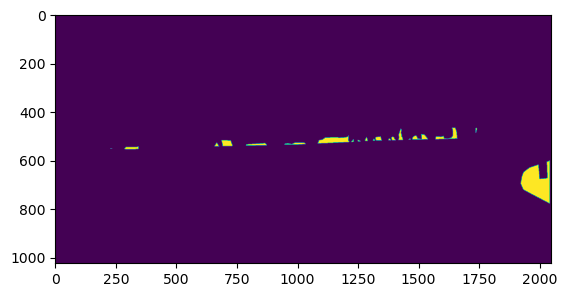

In [236]:
sample_mask, _ = dataset.load_mask(0)
plt.imshow(sample_mask)

In [242]:
dataset.image_info[0]

{'id': 'zurich_000069_000019_leftImg8bit',
 'source': 'cityscape',
 'path': '/Users/csea/Desktop/deep-learning-final-project-project-sidewalk/data/interim/ZIP.leftImg8bit_trainvaltest.zip/leftImg8bit/train/zurich/zurich_000069_000019_leftImg8bit.png'}

In [254]:
def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)

In [238]:
bbox = extract_bboxes(sample_mask)

NameError: name 'extract_bboxes' is not defined

In [195]:
np.unique(x)

array([ 1,  3,  4,  5,  6,  7,  8,  9, 11, 17, 19, 20, 21, 23, 24, 26, 33],
      dtype=uint8)

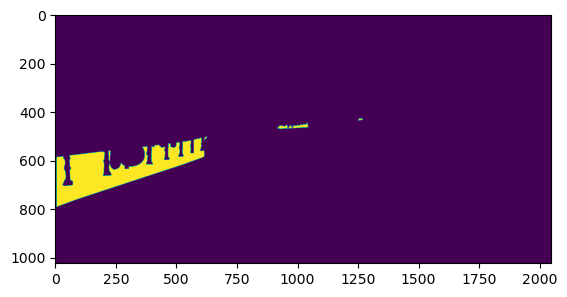

In [196]:
plt.imshow(x==8)

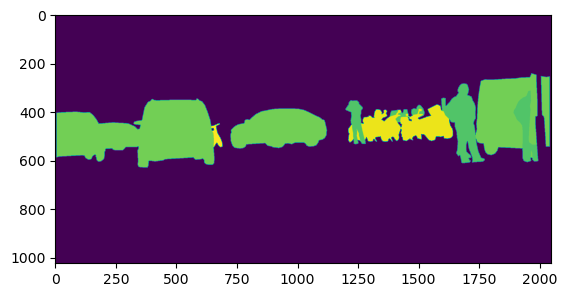

In [251]:
x = skimage.io.imread('/Users/csea/Desktop/deep-learning-final-project-project-sidewalk/data/interim/ZIP.gtFine_trainvaltest.zip/gtFine/train/zurich/zurich_000069_000019_gtFine_instanceIds.png')
plt.imshow(x)

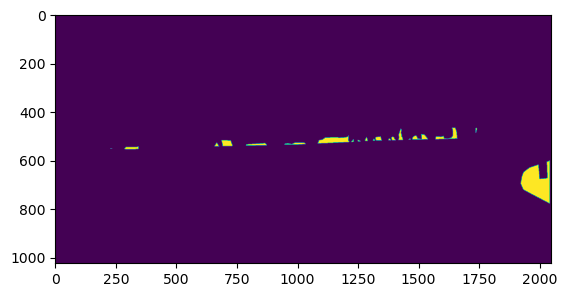

In [252]:
plt.imshow(x==8)

In [255]:
extract_bboxes(x==8)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed